In [1]:
import numpy as np
import os
import cv2
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras.layers import Flatten, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Dense

In [2]:
#Exploration
# Listing all the folders in the data directory "cell_images" folder.
directories = [d for d in os.listdir("cell_images") if os.path.isdir(os.path.join("cell_images", d))]
directories

['Parasitized', 'Uninfected']

Image shape: (121, 142, 3)


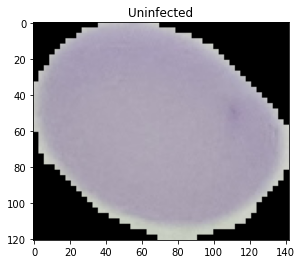

In [3]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class

    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
  
    print(f"Image shape: {img.shape}")
    return img
uninfected_images = view_random_image(target_dir="cell_images/",
                 target_class='Uninfected')

Image shape: (118, 145, 3)


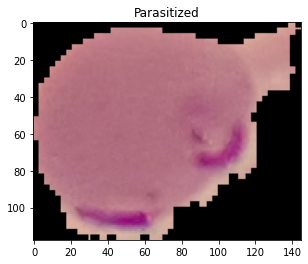

In [4]:
parasitized_images = view_random_image(target_dir="cell_images/",
                 target_class='Parasitized')

In [5]:
#Preprocessing
labels = []
images = []

category = 0 
for d in directories:
    label_dir = os.path.join("cell_images", d)
    
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]
    
    
    for f in file_names:
        img = cv2.imread(f)
        imresize = cv2.resize(img, (200, 125))
        images.append(imresize)
        labels.append(category)
        
            
    category += 1 
    

In [6]:

images = np.array(images)
images.shape


(27558, 125, 200, 3)

In [7]:
labels = np.array(labels)
labels.shape

(27558,)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1234)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22046, 125, 200, 3)
(22046,)
(5512, 125, 200, 3)
(5512,)


In [10]:
#Normalization
from tensorflow.keras.utils import to_categorical


# normalize inputs from [0.0, 255.0] to end up with input in the range [0.0, 1.0]
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train /= 255.0
X_test /= 255.0

# one-hot encoding of the labels
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
print(y_train.shape) 

(22046, 2)


In [12]:
num_classes = y_train.shape[1]
print(num_classes)

2


In [13]:
#Sequential CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(125, 200, 3), activation='relu', strides=(1, 1)))
model.add(Dropout(0.20))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(num_classes, activation='softmax')) 


epochs = 25  
lr = 0.01 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

2022-05-21 15:28:58.539615: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 198, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 123, 198, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 121, 196, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 98, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 48, 32)        0

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=3)

seed = 1234
np.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(history.history['loss']))

2022-05-21 15:29:12.420228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/25
345/345 [==============================] - 944s 3s/step - loss: 1.1990 - accuracy: 0.6075 - val_loss: 0.2681 - val_accuracy: 0.9302
Epoch 2/25
345/345 [==============================] - 1209s 4s/step - loss: 0.2507 - accuracy: 0.9249 - val_loss: 0.1919 - val_accuracy: 0.9427
Epoch 3/25
345/345 [==============================] - 1973s 6s/step - loss: 0.2067 - accuracy: 0.9358 - val_loss: 0.1684 - val_accuracy: 0.9425
Epoch 4/25
345/345 [==============================] - 2198s 6s/step - loss: 0.1749 - accuracy: 0.9411 - val_loss: 0.1655 - val_accuracy: 0.9425
Epoch 5/25
345/345 [==============================] - 2162s 6s/step - loss: 0.1346 - accuracy: 0.9505 - val_loss: 0.1671 - val_accuracy: 0.9454
Epoch 6/25
345/345 [==============================] - 1637s 5s/step - loss: 0.1242 - accuracy: 0.9579 - val_loss: 0.1576 - val_accuracy: 0.9503
Epoch 7/25
345/345 [==============================] - 1821s 5s/step - loss: 0.1021 - accuracy: 0.9625 - val_loss: 0.1846 - val_accuracy: 

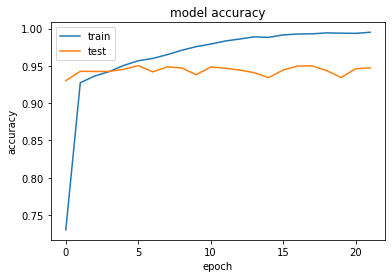

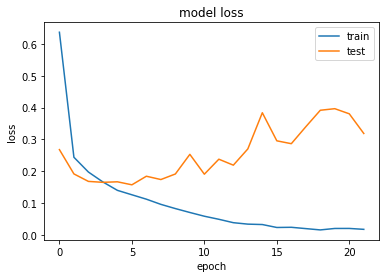

In [15]:
#Validation and model predictions
import matplotlib.pyplot as plt
# summarized history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarized history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [16]:
#Classification Performance Evaluation metrics

from sklearn.metrics import classification_report
preds = model.predict(X_test)
print(preds.shape) 
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.95      2730
  Uninfected       0.93      0.97      0.95      2782

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



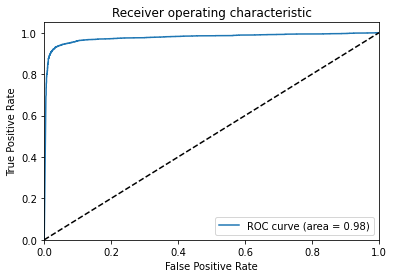

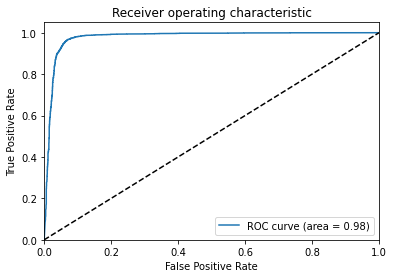

In [17]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
#Xception model with transfer learning

from tensorflow.keras.applications import Xception

base_model = Xception(
    weights='imagenet',  
    input_shape=(125, 200, 3), 
    include_top=False)  

In [19]:
base_model.trainable = False

In [20]:

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(125, 200, 3))
x = base_model(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
x1 = Dense(128, activation='relu')(x1)
outputs = Dense(num_classes, activation='softmax')(x1)
model = Model(inputs, outputs)

epochs = 25 
lr = 0.01 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

callback = EarlyStopping(monitor='loss', patience=3)
seed = 1234

np.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64, callbacks=[callback])

print(len(history.history['loss']))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 200, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 21,124,010
Trainable params: 262,530
Non-trainable params: 20,861,480
_________________________________________________________________
None
Epoch 1/25
345/345 [==============================] - 1803s 5s/step - loss: 0.2352 - accuracy: 0.9052 - 

In [21]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(preds.shape) 
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.96      0.92      0.94      2730
  Uninfected       0.92      0.96      0.94      2782

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



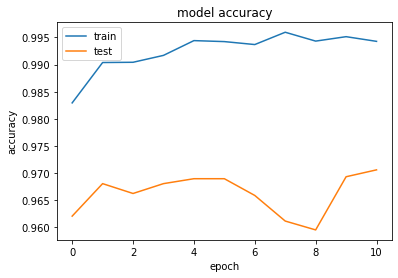

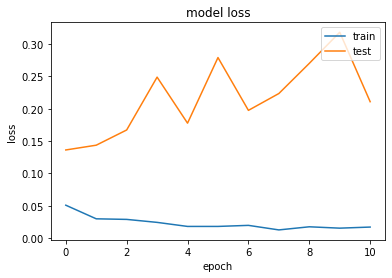

In [26]:
#Validation and model predictions
import matplotlib.pyplot as plt
# summarized history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarized history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

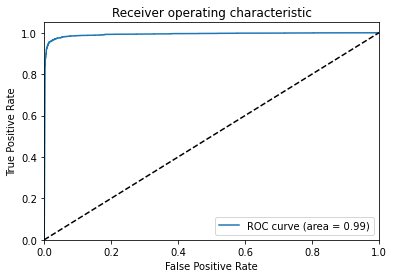

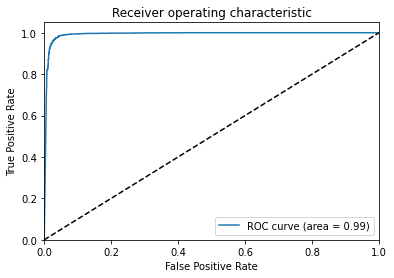

In [27]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [38]:
#Xception Model with fine-tuned hyperparameters
from tensorflow.keras.applications import Xception

base_model = Xception(
    weights='imagenet',  
    input_shape=(125, 200, 3), 
    include_top=False) 

In [24]:
base_model.trainable = True

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(125, 200, 3))
x = base_model(inputs, training=True)
x1 = GlobalAveragePooling2D()(x)

#Addition of extra layers
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
outputs = Dense(num_classes, activation='softmax')(x1)
model = Model(inputs, outputs)

epochs = 25  
lr = 0.1 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = EarlyStopping(monitor='loss', patience=3)
seed = 1234
np.random.seed(seed)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(history.history['loss']))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 125, 200, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0   

In [25]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(preds.shape) 
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.97      0.96      0.97      2730
  Uninfected       0.96      0.98      0.97      2782

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



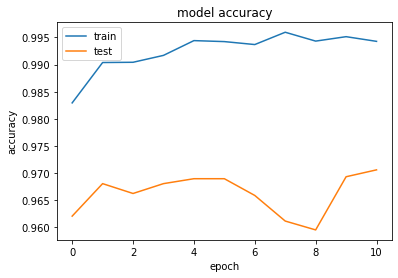

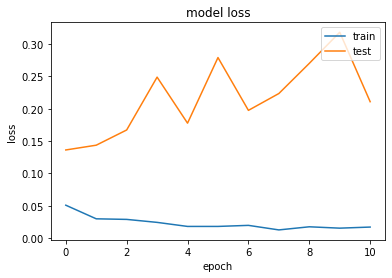

In [34]:
#Validation and model predictions
import matplotlib.pyplot as plt
# summarized history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarized history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

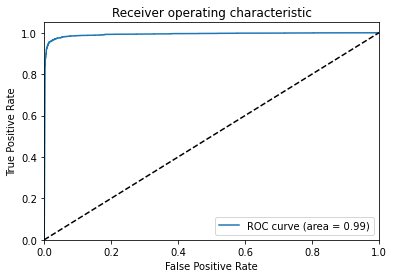

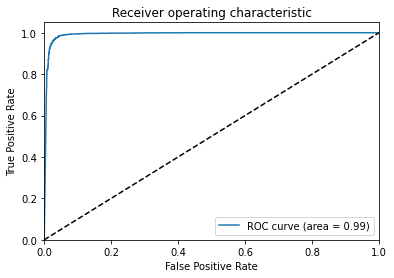

In [35]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
!pip install keras-tuner --upgrade

In [29]:
#Fine-tuning the Sequential model hyperparameters
import keras_tuner as kt
from tensorflow import keras

In [30]:
#Fine-tuning the Sequential model hyperparameters

def build_model(hp):
    
    model = Sequential()
    model.add(Conv2D(hp.Choice('filters', [8, 16, 32]), kernel_size=(3, 3), input_shape=(125, 200, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [31]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(preds.shape) 
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.97      0.96      0.97      2730
  Uninfected       0.96      0.98      0.97      2782

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



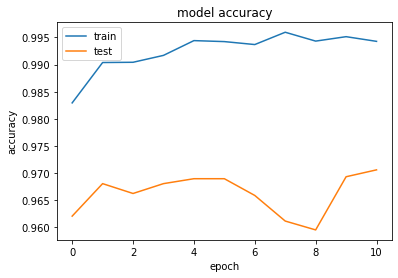

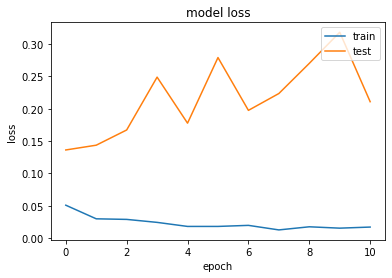

In [36]:
#Validation and model predictions
import matplotlib.pyplot as plt
# summarized history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarized history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

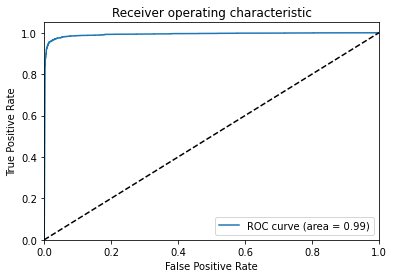

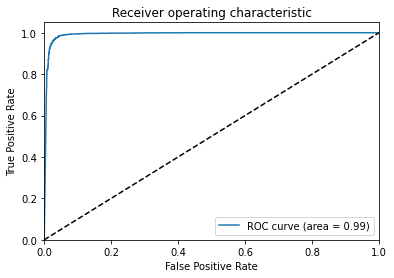

In [37]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [32]:
#Use RandomSearch from keras_tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    overwrite = True)

In [33]:
#Start the search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 3 Complete [01h 28m 43s]
val_loss: 0.1474708765745163

Best val_loss So Far: 0.1389453113079071
Total elapsed time: 03h 21m 52s
INFO:tensorflow:Oracle triggered exit


In [39]:
# VGG-19 model with transfer learning
import tensorflow as tf
tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [40]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(125, 200, 3))
x = base_model(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
x1 = Dense(128, activation='relu')(x1)
outputs = Dense(num_classes, activation='softmax')(x1)
model = Model(inputs, outputs)

epochs = 25 
lr = 0.001 # learning rate
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

callback = EarlyStopping(monitor='loss', patience=3)
seed = 1234

np.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64, callbacks=[callback])

print(len(history.history['loss']))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 125, 200, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 21,124,010
Trainable params: 21,069,482
Non-trainable params: 54,528
_________________________________________________________________
None
Epoch 1/25
345/345 [==============================] - 4891s 14s/step - loss: 0.7729 - accuracy: 0.5053 - 

In [41]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(preds.shape) 
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.50      1.00      0.66      2730
  Uninfected       0.00      0.00      0.00      2782

    accuracy                           0.50      5512
   macro avg       0.25      0.50      0.33      5512
weighted avg       0.25      0.50      0.33      5512



/usr/local/Caskroom/miniforge/base/envs/py3k/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/py3k/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/py3k/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

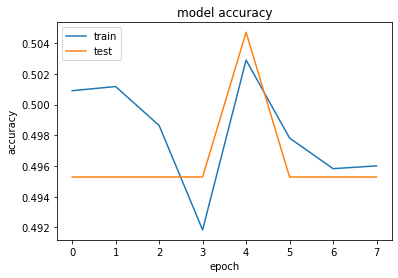

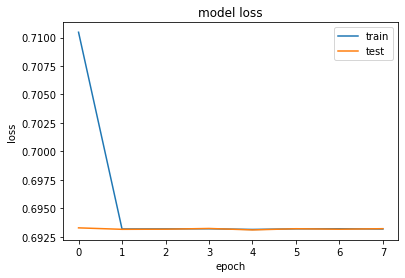

In [42]:
#Validation and model predictions
import matplotlib.pyplot as plt
# summarized history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarized history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

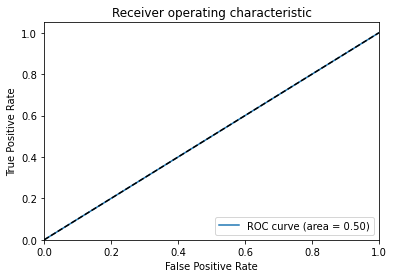

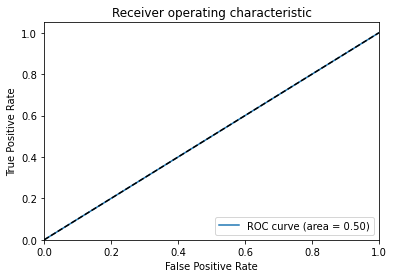

In [43]:
# Computing ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [50]:
# VGG-19 model with fine-tuning
import tensorflow as tf
tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(125, 200, 3),
    pooling=None,
    classes=1000
)

In [51]:
base_model.trainable = True

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(125, 200, 3))
x = base_model(inputs, training=True)
x1 = GlobalAveragePooling2D()(x)

#Addition of extra layers
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
outputs = Dense(num_classes, activation='softmax')(x1)
model = Model(inputs, outputs)

epochs = 25  
lr = 0.1 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = EarlyStopping(monitor='loss', patience=3)
seed = 1234
np.random.seed(seed)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(history.history['loss']))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 125, 200, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0   

KeyboardInterrupt: 

In [52]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)
print(preds.shape) 
preds = np.argmax(preds, axis=1)
print(preds.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, preds, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.97      0.97      0.97      2730
  Uninfected       0.97      0.97      0.97      2782

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



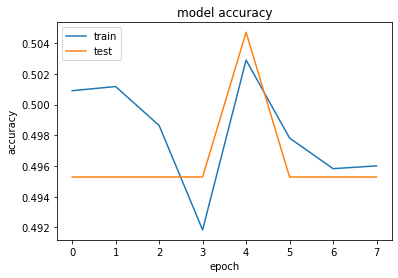

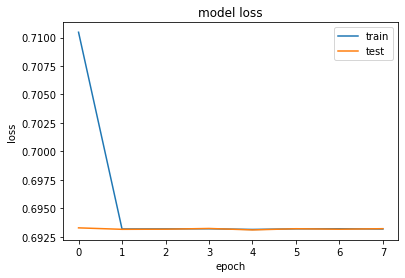

In [53]:
#Validation and model predictions
import matplotlib.pyplot as plt
# summarized history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarized history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

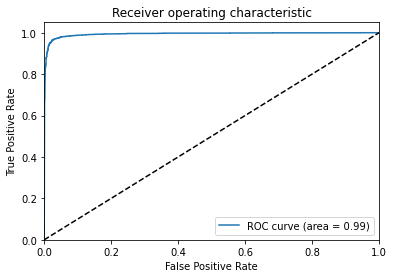

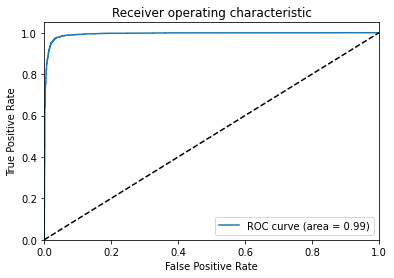

In [54]:
# Computing ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()